In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/анализ контента"

NN_content_analysis.ipynb  Suicide_Detection.csv  weights.02-0.1445.hdf5


In [3]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
# from nltk import word_tokenize

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Input, Dense, LSTM, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, SpatialDropout1D
from keras.models import Model

from keras.callbacks import ModelCheckpoint

# Открытие и обработка данных

In [5]:
try:
  # считывание данных в объект DataFrame библиотеки Pandas
  data = pd.read_csv('/content/drive/My Drive/анализ контента/Suicide_Detection.csv', sep=',')
  data.head()
except FileNotFoundError:
  print('Файл не найден!')

In [7]:
# вывод первых строк
data.head(10)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


In [8]:
# вывод информации об объекта
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [9]:
# вывод уникальных значений из столбца с классами
data['class'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [10]:
# скачивание стоп-слов
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
STOPWORDS = list(set(stopwords.words('english')))

In [12]:
def clean_text(text):
    """Функция для удаления стоп-слов"""

    for word in STOPWORDS:
        text = text.replace(' ' + word + ' ', ' ') 

    return text

In [13]:
# удаление стоп-слов
data['text'] = data['text'].apply(clean_text)

# удаление лишних символов, кроме букв и точки
data['text'] = data['text'].str.replace('[^A-Za-z.]+', ' ')

# приведение текста к нижнему регистру
data['text'] = data['text'].str.lower()

<ipython-input-13-8826ff151514>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('[^A-Za-z.]+', ' ')


In [14]:
# Замена текстовых названий классов числами 0 и 1
data['class'] = data['class'].replace({'suicide':0, 'non-suicide':1})

In [16]:
data.head(10)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left wif...,0
1,3,am i weird i get affected compliments coming s...,1
2,4,finally almost over... so i never hear bad yea...,1
3,8,i need helpjust help im crying hard,0
4,9,i m losthello name adam i ve struggling years ...,0
5,11,honetly idki dont know im even here. i feel li...,0
6,12,trigger warning excuse self inflicted burns i...,0
7,13,it ends tonight.i can t anymore. i quit.,0
8,16,everyone wants edgy making self conscious i fe...,1
9,18,my life years oldhello all. i year old balding...,0


In [17]:
data.loc[0, 'text']

'ex wife threatening suiciderecently i left wife good cheated twice lied much i decided refuse go back her. as days ago began threatening suicide. i tirelessly spent paat days talking keeps hesitating wants believe i ll come back. i know lot people threaten order get way happens really does what i i supposed handle death hands i still love wife i cannot deal getting cheated constantly feeling insecure. i m worried today may day i hope much happen.'

In [18]:
# Формирование обучающей, валидационной и тестовой выборок в пропорциях 60%:10%:30%
# Данные по разным классам записываются в выборки пропорционально

list_class = [0, 1]

data_train = pd.DataFrame()
data_val = pd.DataFrame()
data_test = pd.DataFrame()

for i in list_class:
    len_data_by_class = len(data.loc[data['class'] == i])
    print(i, len_data_by_class)
    
    tmp = data.loc[data['class'] == i].copy()
    np.random.shuffle(tmp.values) # перемешивание
    
    tmp_train = tmp[:int(0.6*len_data_by_class)]
    data_train = data_train.append(tmp_train, ignore_index=True)
    
    tmp_val = tmp[int(0.6*len_data_by_class):int(0.7*len_data_by_class)]
    data_val = data_val.append(tmp_val, ignore_index=True)

    tmp_test = tmp[int(0.7*len_data_by_class):].copy()
    data_test = data_test.append(tmp_test, ignore_index=True)

0 116037
1 116037


<ipython-input-18-77f5b8c4c420>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train = data_train.append(tmp_train, ignore_index=True)
<ipython-input-18-77f5b8c4c420>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_val = data_val.append(tmp_val, ignore_index=True)
<ipython-input-18-77f5b8c4c420>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_test = data_test.append(tmp_test, ignore_index=True)


In [19]:
print('Количество примеров в обучающей выборке', len(data_train))
print('Количество примеров в валидационной выборке',len(data_val))
print('Количество примеров в тестовой выборке',len(data_test))

Количество примеров в обучающей выборке 139244
Количество примеров в валидационной выборке 23206
Количество примеров в тестовой выборке 69624


#Токенизация признаков

In [23]:
# максимальное количество слов для анализа
MAX_NB_WORDS = 50000
# максимальное количество слов в каждом наборе
MAX_SEQUENCE_LENGTH = 500

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Найдено уникальных токенов:', len(word_index))

Найдено уникальных токенов: 150923


In [24]:
# кодирование признаков
X_train = tokenizer.texts_to_sequences(data_train['text'].values)
X_val = tokenizer.texts_to_sequences(data_val['text'].values)
X_test = tokenizer.texts_to_sequences(data_test['text'].values)

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
# создание массивов с классами
Y_train = data_train['class'].values
Y_val = data_val['class'].values
Y_test = data_test['class'].values

In [26]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(139244, 500) (139244,)
(23206, 500) (23206,)
(69624, 500) (69624,)


# Обучение нейронной сети

In [27]:
EMBEDDING_DIM = 300

inputs = Input(shape=(X_train.shape[1],))
embeddings = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(inputs)

x = SpatialDropout1D(0.2)(embeddings)
x = LSTM(128, dropout=0.2, return_sequences=True)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Conv1D(128, 1, activation='relu')(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          15000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 500, 128)          219648    
                                                                 
 conv1d (Conv1D)             (None, 498, 128)          49280     
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 128)          16512     
                                                             

In [30]:
epochs = 3
batch_size = 128

checkpointer = ModelCheckpoint(
    filepath='/content/drive/My Drive/анализ контента/weights.{epoch:02d}-{val_loss:.4f}.hdf5',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

history = model.fit(
    x = X_train, 
    y = Y_train, 
    epochs = epochs, 
    batch_size = batch_size, 
    validation_data = (X_val, Y_val), 
    callbacks = [checkpointer])

Epoch 1/3
1088/1088 [==============================] - 215s 185ms/step - loss: 0.1938 - accuracy: 0.9251 - val_loss: 0.1703 - val_accuracy: 0.9448
Epoch 2/3
1088/1088 [==============================] - 113s 104ms/step - loss: 0.1282 - accuracy: 0.9527 - val_loss: 0.1489 - val_accuracy: 0.9458
Epoch 3/3
1088/1088 [==============================] - 98s 90ms/step - loss: 0.0993 - accuracy: 0.9644 - val_loss: 0.1444 - val_accuracy: 0.9458


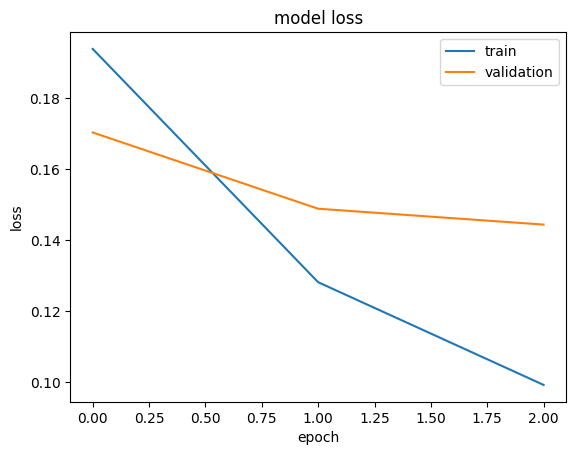

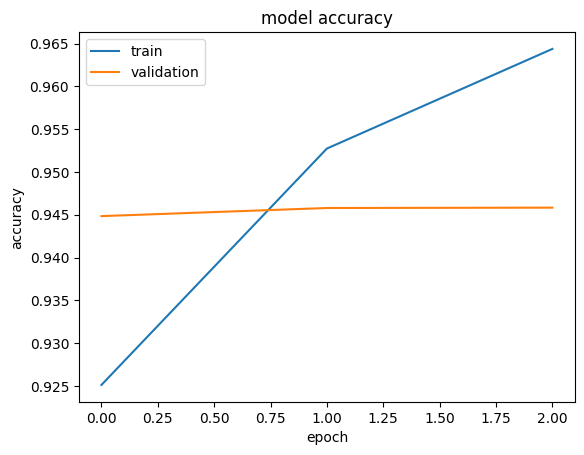

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')


plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.show()

# Проверка обученной сети

In [ ]:
# загрузка лучших весов
model.load_weights('/content/drive/My Drive/анализ контента/weights.03-0.1444.hdf5')

In [32]:
accr_1 = model.evaluate(X_train, Y_train, batch_size = batch_size)
print('Обучающая выборка\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr_1[0],accr_1[1]))

accr_2 = model.evaluate(X_val, Y_val, batch_size = batch_size)
print('Валидационная выборка\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr_2[0],accr_2[1]))

accr_3 = model.evaluate(X_test, Y_test, batch_size = batch_size)
print('Тестовая выборка\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr_3[0],accr_3[1]))

1088/1088 [==============================] - 24s 22ms/step - loss: 0.0717 - accuracy: 0.9774
Обучающая выборка
  Loss: 0.0717
  Accuracy: 0.9774
182/182 [==============================] - 4s 23ms/step - loss: 0.1444 - accuracy: 0.9458
Валидационная выборка
  Loss: 0.1444
  Accuracy: 0.9458
544/544 [==============================] - 12s 22ms/step - loss: 0.1481 - accuracy: 0.9441
Тестовая выборка
  Loss: 0.1481
  Accuracy: 0.9441
